In [1]:
import ta
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import quantstats as qs

In [2]:
df = yf.download('ETH-USD', start= '2021-01-01', interval = "1h")

[*********************100%***********************]  1 of 1 completed


In [3]:
df['EMA_fast'] = ta.trend.ema_indicator(df.Close, window=13)
df['EMA_slow'] = ta.trend.ema_indicator(df.Close, window=62)
df['rsi'] = ta.momentum.rsi(df.Close, window=12)
df['macd'] = ta.trend.macd_diff(df.Close)

In [4]:
df.dropna(inplace=True)

In [5]:
df['Buy'] = np.where((df['EMA_fast'] > df['EMA_slow'])  & (df.rsi > 50) & (df.macd > 0),1,0)

In [6]:
df['Sell'] = np.where((df['EMA_fast'] < df['EMA_slow']),1,0) 

In [7]:
Buying_dates, Selling_dates = [], []

In [8]:
for i in range(len(df)-1):
    if df.Buy.iloc[i]:
        Buying_dates.append(df.iloc[i+1].name)
        for num,j in enumerate(df.Sell[i:]):
            if j:
                Selling_dates.append(df.iloc[i + num + 1].name)
                break
        

In [9]:
cut = len(Buying_dates) - len(Selling_dates)

In [10]:
if cut:
    Buying_dates = Buying_dates[:-cut]    

In [11]:
frame = pd.DataFrame({'Buying_dates':Buying_dates, 'Selling_dates':Selling_dates})

In [12]:
actual_trades = frame[frame.Buying_dates > frame.Selling_dates.shift(1)]

In [13]:
x = actual_trades['Selling_dates'] - actual_trades['Buying_dates']
x.mean()

Timedelta('2 days 20:16:31.304347826')

In [14]:
def profitcalc():
    Buyprices = df.loc[actual_trades.Buying_dates].Open
    Sellprices = df.loc[actual_trades.Selling_dates].Open
    return (Sellprices.values - Buyprices.values)/Buyprices.values

In [15]:
profits = profitcalc()
qs_profits = pd.Series(profits, index= actual_trades['Selling_dates'])
qs_profits.index = qs_profits.index.date
qs_profits

2021-01-21    0.124450
2021-01-23   -0.030927
2021-01-26    0.056719
2021-01-31   -0.008440
2021-02-07    0.181819
                ...   
2021-11-26   -0.045843
2021-12-02    0.045410
2021-12-03   -0.047881
2021-12-09   -0.019837
2021-12-13   -0.039153
Length: 69, dtype: float64

In [16]:
profits_df = pd.DataFrame(profits)
profits_df.set_axis(['Returns'], axis=1, inplace=True)

In [17]:
real_profits = profits - .00075

In [18]:
# Sortino based off a heap of assumptions. 

sharpe_ratio = profits.mean() / profits.std()
A_sharpe_ratio = (126**0.5) * sharpe_ratio
A_sharpe_ratio

2.213978645263734

In [19]:
# Average profits to date
profits.mean()*100

2.0549469320826645

In [20]:
# cumulative profits 
(profits+1).prod()*100 - 100

201.92018397310363

In [21]:
average_profit = sum(profits)/len(profits)*100
largest_gain = max(profits)*100
biggest_loss = min(profits)*100

In [22]:
print(f'Average Profit =',average_profit,'%')
print(f'Largest Gain =',largest_gain,'%')
print(f'Biggest Loss =',biggest_loss,'%')

Average Profit = 2.0549469320826645 %
Largest Gain = 63.087824623567656 %
Biggest Loss = -7.8943195235673835 %


In [23]:
# anualised profits

((profits.mean() + 1)**(52))-1

1.8798587233502118

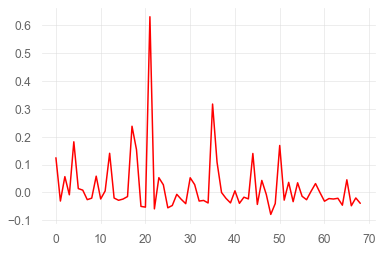

In [24]:
plt.plot(profits, color="red")

In [25]:
cumulative_profits =np.cumsum(profits)

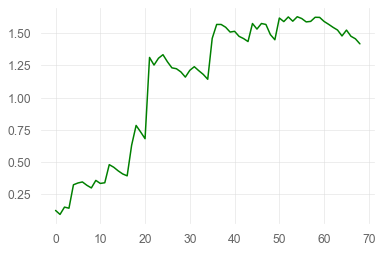

In [26]:
plt.plot(cumulative_profits, color="green")

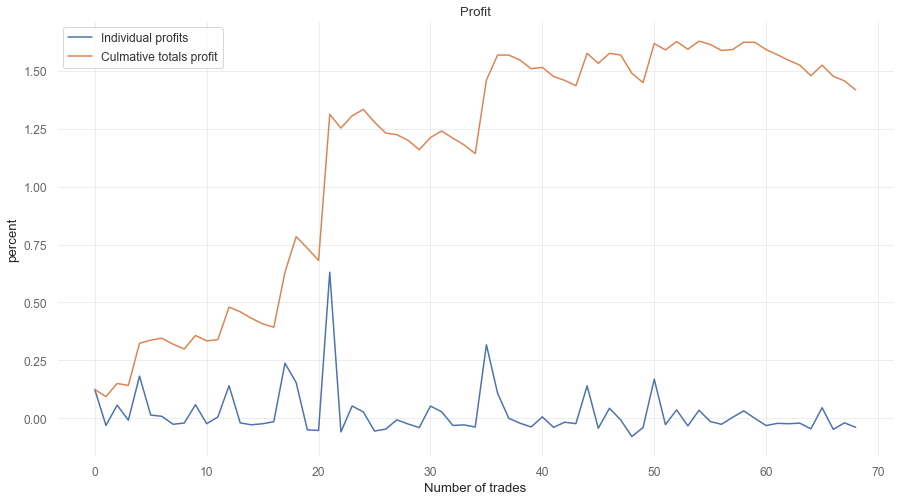

In [27]:
# line 1 points
x1 = profits
plt.figure(figsize=(15,8))
# plotting the line 1 points
plt.plot(x1, label = "Individual profits")
 
# line 2 points
x2 = cumulative_profits

# plotting the line 2 points
plt.plot(x2, label = "Culmative totals profit")
 
# naming the x axis
plt.xlabel('Number of trades')
# naming the y axis
plt.ylabel('percent')
# giving a title to my graph
plt.title('Profit')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()



In [28]:
# Quant stats back test reporting
qs.extend_pandas()
stock = qs_profits 
qs.stats.sharpe(stock)
stock.sharpe()
stock.index=pd.to_datetime(stock.index)

stock = stock.groupby(stock.index).sum()
print(stock.index)

DatetimeIndex(['2021-01-21', '2021-01-23', '2021-01-26', '2021-01-31',
               '2021-02-07', '2021-02-11', '2021-02-15', '2021-02-16',
               '2021-02-21', '2021-03-04', '2021-03-11', '2021-03-12',
               '2021-03-15', '2021-03-18', '2021-03-21', '2021-04-07',
               '2021-04-17', '2021-04-23', '2021-04-25', '2021-05-13',
               '2021-05-15', '2021-05-28', '2021-06-04', '2021-06-05',
               '2021-06-08', '2021-06-10', '2021-06-16', '2021-06-25',
               '2021-07-01', '2021-07-05', '2021-07-08', '2021-07-12',
               '2021-07-18', '2021-08-03', '2021-08-09', '2021-08-12',
               '2021-08-15', '2021-08-16', '2021-08-22', '2021-08-24',
               '2021-08-29', '2021-08-30', '2021-09-07', '2021-09-13',
               '2021-09-17', '2021-09-18', '2021-09-24', '2021-09-28',
               '2021-10-10', '2021-10-11', '2021-10-17', '2021-10-18',
               '2021-10-22', '2021-10-24', '2021-10-27', '2021-10-31',
      

In [29]:
qs.reports.html(stock[1:], "spy", output="output.html")